<div style="display: flex; align-items: center; justify-content: space-between; border-bottom: 3px solid #D0D0D0; padding: 10px; font-family: Arial, sans-serif;">
  <!-- Logo -->
  <img src="https://upload.wikimedia.org/wikipedia/commons/1/1c/Uoc_masterbrand_vertical.png" alt="Logo" style="width: 150px; height: auto;">

  <!-- Detalles -->
  <div style="text-align: right; line-height: 1.6; margin-left: 20px; margin-right: 80px">
    <p style="margin: 0; font-size: 1.2em; font-weight: bold; color: #333;">Proyecto: <span style="color: #878787;">Práctica - Parte 2</span></p>
    <p style="margin: 0; font-size: 1em; font-weight: bold; color: #333;">Notebook: <span style="color: #878787;">Exploración inicial de datos del cuestionario</span></p>
    <p style="color: #878787;">Juan Luis González Rodríguez - Visualización de datos</span></p>
  </div>
</div>

# 0. Librerías

In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# 1.Exploración y limpieza de datos

Cada usuario tiene una carpeta llamada user_1, user_2, user_3, etc. De manera que d entro de cada carpeta hay un archivo CSV llamado questionnaire.csv. Se carga toda la información de los archivos CSV en un solo DataFrame.

In [33]:
# Creamos un df vacio
df_quest = pd.DataFrame()

# Obtenemos la lista con los paths de los archivos
data_path = os.path.join('..', '0_data', 'MMASH')
csv_files = [os.path.join(root, file) for root, _, files in os.walk(data_path) for file in files if file.endswith('questionnaire.csv')]

# Iteramos sobre los archivos
for file in csv_files:
    # Leemos el archivo
    df = pd.read_csv(file, usecols=lambda column: column != 'Unnamed: 0')
    # Extraemos el identificador del usuario del nombre del fichero
    user_id = os.path.basename(os.path.dirname(file))
    # Añadimos la columna 'User' al dataframe
    df['User'] = user_id
    # Concatenamos el df al df principal
    df_quest = pd.concat([df_quest, df])

# Reseteamos el índice
df_quest.reset_index(drop=True, inplace=True)

# Se establece user como la primera columna
df_quest = df_quest[['User'] + [col for col in df_quest.columns if col != 'User']]

# Visualizamos el df
df_quest.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   User           22 non-null     object 
 1   MEQ            22 non-null     float64
 2   STAI1          22 non-null     float64
 3   STAI2          22 non-null     float64
 4   Pittsburgh     22 non-null     float64
 5   Daily_stress   22 non-null     float64
 6   BISBAS_bis     22 non-null     float64
 7   BISBAS_reward  22 non-null     float64
 8   BISBAS_drive   22 non-null     float64
 9   BISBAS_fun     22 non-null     float64
 10  panas_pos_10   22 non-null     float64
 11  panas_pos_14   21 non-null     float64
 12  panas_pos_18   22 non-null     float64
 13  panas_pos_22   22 non-null     float64
 14  panas_pos_9+1  22 non-null     float64
 15  panas_neg_10   22 non-null     float64
 16  panas_neg_14   21 non-null     float64
 17  panas_neg_18   22 non-null     float64
 18  panas_neg_22

Casi todos los registros tienen 22 valores no nulos, salvo *panas_pos_14* y *panas_neg_14*, que presentan un valor nulo en cada caso.

In [34]:
# Se meuestran las filas de los datos con valores nulos
df_quest[df_quest.isnull().any(axis=1)]

,User,MEQ,STAI1,STAI2,Pittsburgh,Daily_stress,BISBAS_bis,BISBAS_reward,BISBAS_drive,BISBAS_fun,panas_pos_10,panas_pos_14,panas_pos_18,panas_pos_22,panas_pos_9+1,panas_neg_10,panas_neg_14,panas_neg_18,panas_neg_22,panas_neg_9+1
15,user_13,48.0,30.0,43.0,4.0,27.0,22.0,19.0,14.0,12.0,22.0,NaN,26.0,14.0,23.0,13.0,NaN,11.0,13.0,12.0


Todos los valores nulos pertenecen al cuestionario del usuario 13. Además, en el estudio original que presenta el conjunto de datos [1], se menciona que el usuario 7 no ha rellenado los valores para el campo STAI-Y 2. Se procede a visualizar también al usuario 7.

In [35]:
df_quest[df_quest['User'].isin(['user_7', 'user_13'])]

,User,MEQ,STAI1,STAI2,Pittsburgh,Daily_stress,BISBAS_bis,BISBAS_reward,BISBAS_drive,BISBAS_fun,panas_pos_10,panas_pos_14,panas_pos_18,panas_pos_22,panas_pos_9+1,panas_neg_10,panas_neg_14,panas_neg_18,panas_neg_22,panas_neg_9+1
10,user_7,46.0,33.0,0.0,7.0,69.0,19.0,19.0,12.0,6.0,22.0,13.0,13.0,11.0,13.0,11.0,13.0,16.0,14.0,13.0
15,user_13,48.0,30.0,43.0,4.0,27.0,22.0,19.0,14.0,12.0,22.0,NaN,26.0,14.0,23.0,13.0,NaN,11.0,13.0,12.0


In [36]:
# Se imputa como NA el valor de la variable STAI2 del usuario user_7
df_quest.loc[df_quest['User'] == 'user_7', 'STAI2'] = pd.NA

Se observa que el usuario 7 presenta un valor de 0 en la columna STAI2. Pero el rango de valores de la escala STAI2 es de 20 a 80. Por lo que se considera que el valor 0 es un valor nulo.
A continuación se proceden a comprobar que las variables están dentro del rango de valores permitidos.

In [37]:
# Definimos los rangos permitidos para cada columna en función del paper de referencia [1]
ranges = {
    'MEQ': (16, 86),
    'STAI1': (20, 80),
    'STAI2': (20, 80),
    'Pittsburgh': (0, 21),
    'Daily_stress': (0, 406),
    'BISBAS_bis': (0, 100),  # Asumiendo un rango de 0 a 100 para BIS/BAS
    'BISBAS_reward': (0, 100),
    'BISBAS_drive': (0, 100),
    'BISBAS_fun': (0, 100),
    'panas_pos_10': (5, 50),
    'panas_pos_14': (5, 50),
    'panas_pos_18': (5, 50),
    'panas_pos_22': (5, 50),
    'panas_pos_9+1': (5, 50),
    'panas_neg_10': (5, 50),
    'panas_neg_14': (5, 50),
    'panas_neg_18': (5, 50),
    'panas_neg_22': (5, 50),
    'panas_neg_9+1': (5, 50)
}

# Comprobamos que los valores están en el rango permitido, ignorando los NA
for column, (min_val, max_val) in ranges.items():
    out_of_range = df_quest[~df_quest[column].between(min_val, max_val, inclusive='both') & df_quest[column].notna()]
    if not out_of_range.empty:
        for index, row in out_of_range.iterrows():
            print(f"Usuario: {row['User']}, Columna: {column}, Valor: {row[column]}")
    else:
        print(f"Todos los valores de la columna {column} están en rango")

Todos los valores de la columna MEQ están en rango
Todos los valores de la columna STAI1 están en rango
Todos los valores de la columna STAI2 están en rango
Todos los valores de la columna Pittsburgh están en rango
Todos los valores de la columna Daily_stress están en rango
Todos los valores de la columna BISBAS_bis están en rango
Todos los valores de la columna BISBAS_reward están en rango
Todos los valores de la columna BISBAS_drive están en rango
Todos los valores de la columna BISBAS_fun están en rango
Todos los valores de la columna panas_pos_10 están en rango
Todos los valores de la columna panas_pos_14 están en rango
Todos los valores de la columna panas_pos_18 están en rango
Todos los valores de la columna panas_pos_22 están en rango
Todos los valores de la columna panas_pos_9+1 están en rango
Todos los valores de la columna panas_neg_10 están en rango
Todos los valores de la columna panas_neg_14 están en rango
Todos los valores de la columna panas_neg_18 están en rango
Todos l

Se comprueba que todos los valores de las columnas están en rango, aunque tengamos valores NA en algunas columnas.

Para solucionar los valores perdidos de *panas_pos_14* y *panas_neg_14*, se utilizará la interpolación, ya que estos valores son parte de una serie temporal.

De esta manera, *panas_pos_14* se interpolará entre *panas_pos_10* y *panas_pos_18*.
Por otro lado, *panas_neg_14* se interpolará entre *panas_neg_10* y *panas_neg_18*.

In [38]:
# Se interpola la variable pana_pos_14 para el user_13
df_quest.loc[df_quest['User'] == 'user_13', 'panas_pos_14'] = df_quest.loc[df_quest['User'] == 'user_13', ['panas_pos_10', 'panas_pos_18']].mean(axis=1)
df_quest.loc[df_quest['User'] == 'user_13', 'panas_neg_14'] = df_quest.loc[df_quest['User'] == 'user_13', ['panas_neg_10', 'panas_neg_18']].mean(axis=1)

In [39]:
df_quest[df_quest['User'] == 'user_13'][['User', 'panas_pos_10', 'panas_pos_14', 'panas_pos_18', 'panas_neg_10', 'panas_neg_14', 'panas_neg_18']]

,User,panas_pos_10,panas_pos_14,panas_pos_18,panas_neg_10,panas_neg_14,panas_neg_18
15,user_13,22.0,24.0,26.0,13.0,12.0,11.0


**MEQ**

Valores inferiores a 41 indican una preferencia ser más activo durante la noche, entre 42 y 58 intermedio y superiores a 59 matutino.

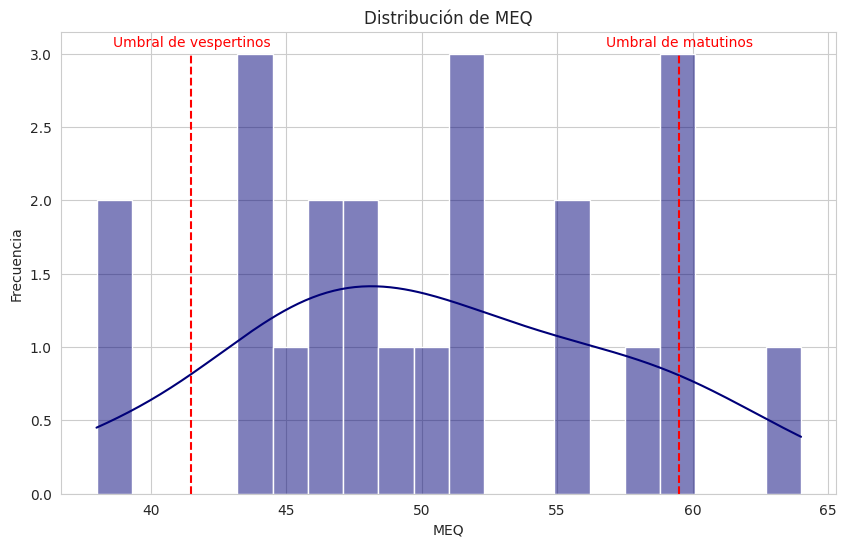

In [40]:
# Mostramos un histograma de MEQ
sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data=df_quest, x='MEQ', bins=20, kde=True, color="#000078")
plt.vlines(x=41.5, ymin=0, ymax=3, color='r', linestyle='--')
plt.text(41.5, 3.05, 'Umbral de vespertinos', color='r', ha='center')
plt.vlines(x=59.5, ymin=0, ymax=3, color='r', linestyle='--')
plt.text(59.5, 3.05, 'Umbral de matutinos', color='r', ha='center')
plt.title('Distribución de MEQ')
plt.xlabel('MEQ')
plt.ylabel('Frecuencia')

plt.show()

Se observa que la mayoría tiene un comportamiento intermedio, aunque tienden más a ser más activos de noche que de mañana. Aunque se advierte que hay unos grupos claramente marcados como "matutinos" y "vespertinos". En el caso del grupo intermedio, se observa mucha variabilidad y no es lo mismo agrupar a una persona con un MEQ de 43, muy cercano a un comportamiento nocturno, que a una con un MEQ de 58, muy cercano a un comportamiento matutino. Por lo que se decide no categorizarla y mantenerla como una variable numérica.

**STAI 1 y STAI 2**

Las variables STAI1 y STAI2 del cuestionario STAI miden la ansiedad. STAI1 evalúa la ansiedad estado, que varía según el contexto y tiene un rango de 20 a 80, donde <31 indica baja ansiedad, 31-49 ansiedad promedio, y >50 alta ansiedad. STAI2 mide la ansiedad rasgo, una predisposición estable a experimentar ansiedad, con el mismo rango de puntuaciones y categorización. STAI1 es útil para medir reacciones a situaciones estresantes inmediatas, mientras que STAI2 identifica tendencias generales de ansiedad, útil para correlacionar con factores como el estrés crónico y la calidad del sueño.


In [41]:
df_quest[['STAI1', 'STAI2']]

,STAI1,STAI2
0,41.0,43.0
1,28.0,40.0
2,34.0,49.0
3,38.0,35.0
4,24.0,39.0
5,27.0,33.0
6,52.0,42.0
7,32.0,39.0
8,36.0,43.0
9,41.0,48.0


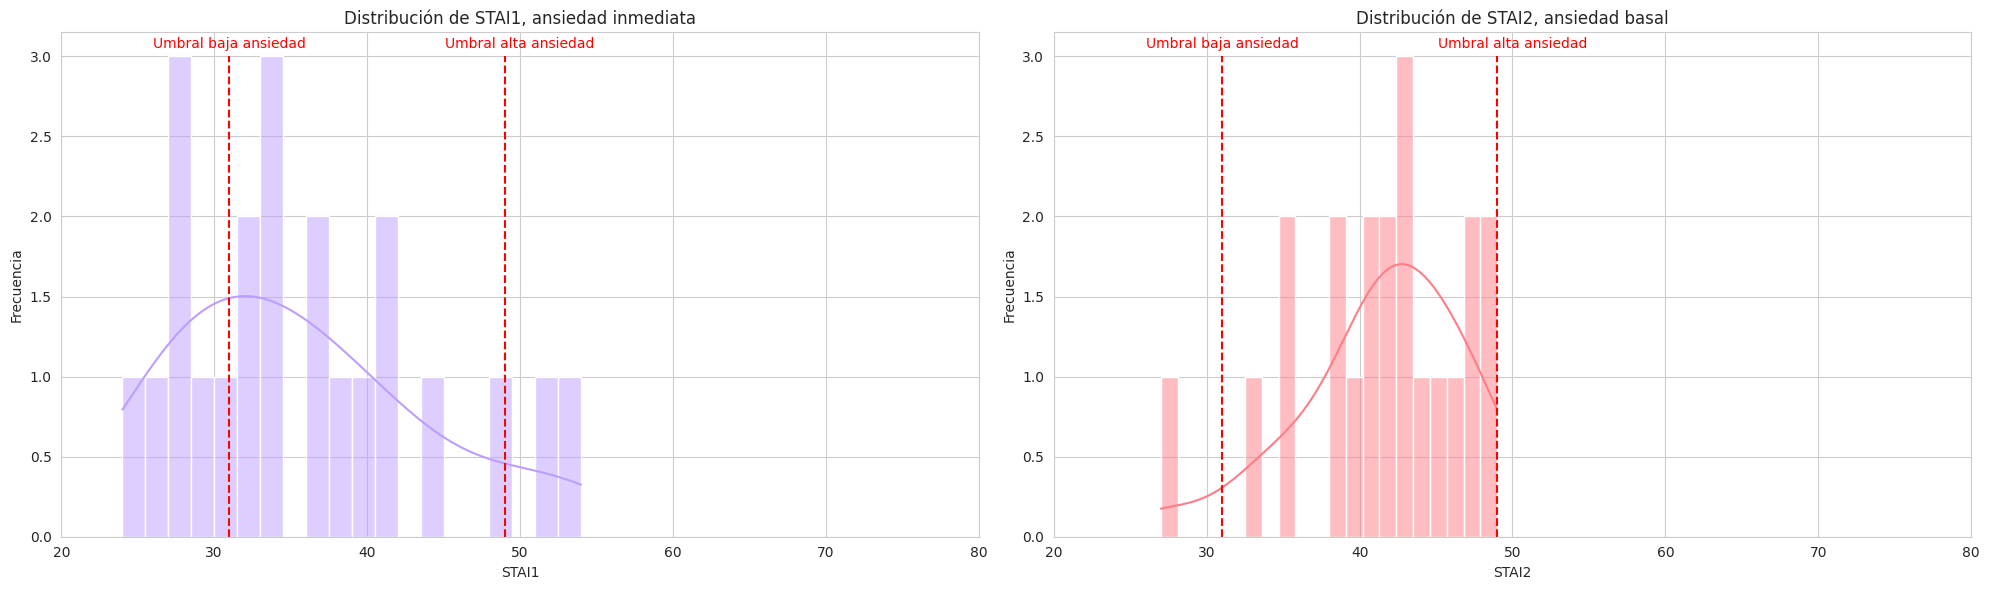

In [42]:
# Histograma de STAI1 y STAI2
sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Histograma de STAI1
sns.histplot(data=df_quest, x='STAI1', bins=20, kde=True, color="#BD9EFF", ax=axes[0])
axes[0].vlines(x=31, ymin=0, ymax=3, color='r', linestyle='--')
axes[0].text(31, 3.05, 'Umbral baja ansiedad', color='r', ha='center')
axes[0].vlines(x=49, ymin=0, ymax=3, color='r', linestyle='--')
axes[0].text(50, 3.05, 'Umbral alta ansiedad', color='r', ha='center')
axes[0].set_title('Distribución de STAI1, ansiedad inmediata')
axes[0].set_xlabel('STAI1')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xlim(20, 80)

# Histograma de STAI2
sns.histplot(data=df_quest, x='STAI2', bins=20, kde=True, color="#FF7D87", ax=axes[1])
axes[1].vlines(x=31, ymin=0, ymax=3, color='r', linestyle='--')
axes[1].text(31, 3.05, 'Umbral baja ansiedad', color='r', ha='center')
axes[1].vlines(x=49, ymin=0, ymax=3, color='r', linestyle='--')
axes[1].text(50, 3.05, 'Umbral alta ansiedad', color='r', ha='center')
axes[1].set_title('Distribución de STAI2, ansiedad basal')
axes[1].set_xlabel('STAI2')
axes[1].set_ylabel('Frecuencia')
axes[1].set_xlim(20, 80)

plt.tight_layout()
plt.show()

En general, se observa que los participantes tienden a reportar una ansiedad inmediata más baja en comparación con su ansiedad basal. Será interesante investigar si existe una correlación entre ambas variables. Además, se nota que solo 2 o 3 usuarios alcanzan niveles de alta ansiedad, y todos ellos con valores por debajo de 55 (cuando el máximo es 80). En el caso de la ansiedad basal medida con STAI2, aunque la tendencia general muestra valores más altos que en STAI1, estos valores se mantienen en el rango intermedio. Prácticamente nadie se identifica con una ansiedad que supere el umbral de alta ansiedad. A continuación Analizaremos ambas distribuciones en un diagrama violin-plot. para estudiar como se comportan ambas en términos de variabilidad.

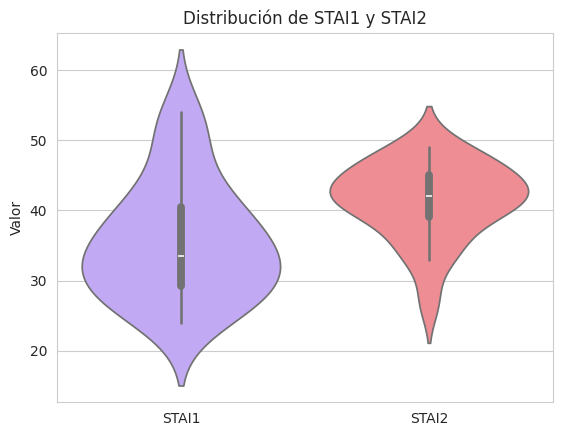

In [43]:
# Violin plot de ambas STAI1 y STAI2
sns.set_style('whitegrid')

plt.figsize=(10, 6)
sns.violinplot(data=df_quest[['STAI1', 'STAI2']], palette=['#BD9EFF', '#FF7D87'])
plt.title('Distribución de STAI1 y STAI2')
plt.ylabel('Valor')
plt.show()

Se afirma lo que se venía comentando en el gráfico anterior. Por un lado, STAI2 (la ansiedad basal) tiene unos valores más altos que STAI1 (la ansiedad inmediata) y se encuentra más concentrada. Por otro lado, STAI1 tiene una distribución más dispersa y encontramos valores más altos y más bajos, aunque en general la tendencia es que aquí los valores sean menores que en la STAI2.

A continuación, se muestra un gráfico de dispersión que nos ayudará a entender cómo se relaciona cada variable.

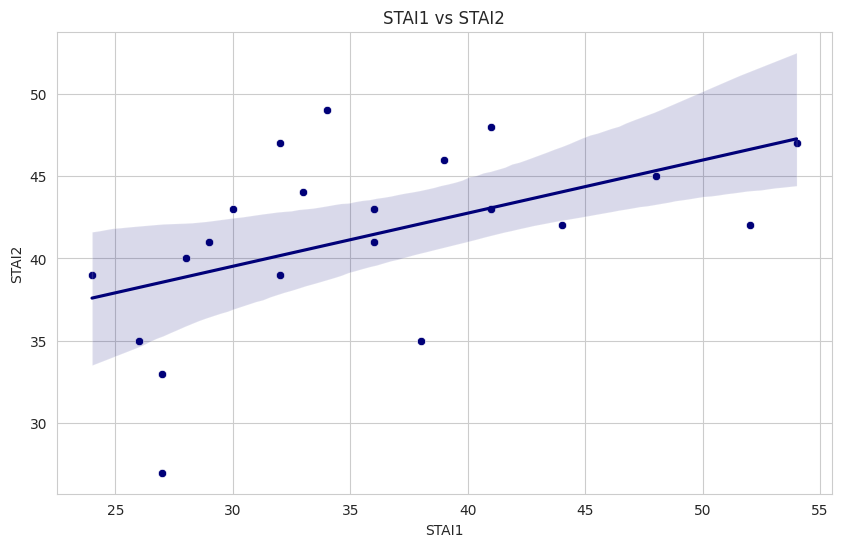

In [44]:
# Scatter plot de STAI1 y STAI2
sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_quest, x='STAI1', y='STAI2', color='#000078')
sns.regplot(data=df_quest, x='STAI1', y='STAI2', scatter=False, color='#000078', ci=95)
plt.title('STAI1 vs STAI2')
plt.xlabel('STAI1')
plt.ylabel('STAI2')
plt.show()

Se observa que para los valores bajos de STAI1 se encuentran valores más bajos de STAI2 (en términos relativos dentro de los valores que toma cada variable). Para valores intermedios en el rango de 30 a 55 no parece haber una relación tan clara, más allá de que se siguen tomando valores intermedios para la otra variable. No se dispone de información para valores superiores a 50/55 hasta 80, por lo que no se puede predecir el comportamiento en este rango de valores.

Existe una relación entre los valores bajos de STAI1 y STAI2, pero esta relación no es evidente en los valores intermedios. La falta de datos en el rango superior impide hacer predicciones sobre el comportamiento en esos valores. Simplemente se puede resaltar que valores bajos o intermedios-bajos de una variable se asocian con valores análogos en la otra variable. Lo mismo sucede con los valores intermedios.

**Pittsburgh**

El Pittsburgh Sleep Quality Index (PSQI) es un cuestionario diseñado para evaluar la calidad del sueño en el último mes. Genera una puntuación global que va de 0 a 21, donde valores más altos indican peor calidad del sueño. Se compone de siete componentes, como duración, latencia, eficiencia del sueño, y disfunción diurna. Una puntuación inferior a 6 indica una buena calidad del sueño en el último mes.

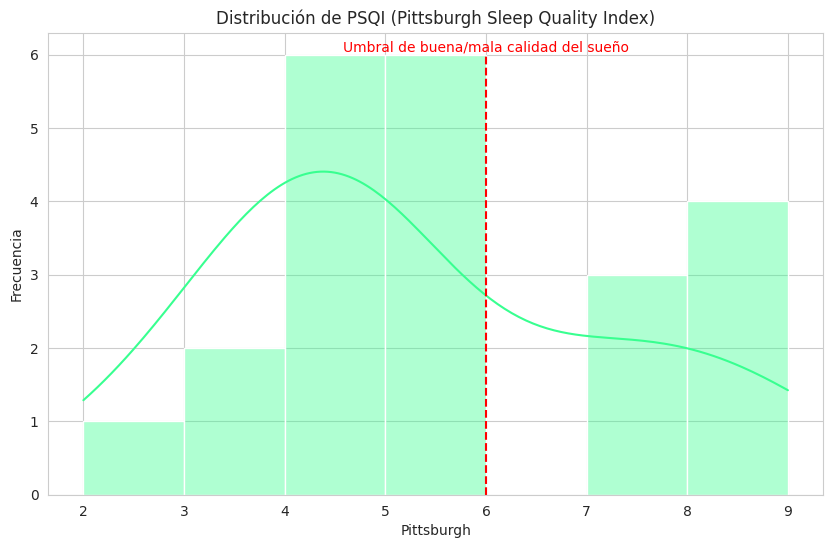

In [45]:
# Se muestra el histograma de Pittsburgh
sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data=df_quest, x='Pittsburgh', bins=range(2,10,1), kde=True, color="#38FF90", alpha=0.4)
plt.vlines(x=6, ymin=0, ymax=6, color='r', linestyle='--')
plt.text(6, 6.05, 'Umbral de buena/mala calidad del sueño', color='r', ha='center')
plt.title('Distribución de PSQI (Pittsburgh Sleep Quality Index)')
plt.xlabel('Pittsburgh')
plt.ylabel('Frecuencia')

plt.show()

Se observa que la mayoría de los usuarios tienen un PSQI por debajo de 6, lo que indica una buena calidad del sueño. No obstante, se encuentra otro grupo de usuarios con PSQI de 7 y 8. Aunque, al igual que con la ansiedad, estos valores son bajos en comparación con el rango de posibles valores que va de 0 a 21.

Es interesante estudiar cómo se comporta el PSQI, que mide la calidad del sueño del último mes, con STAI2, que mide la ansiedad basal. Para ello, se realiza un gráfico de dispersión.

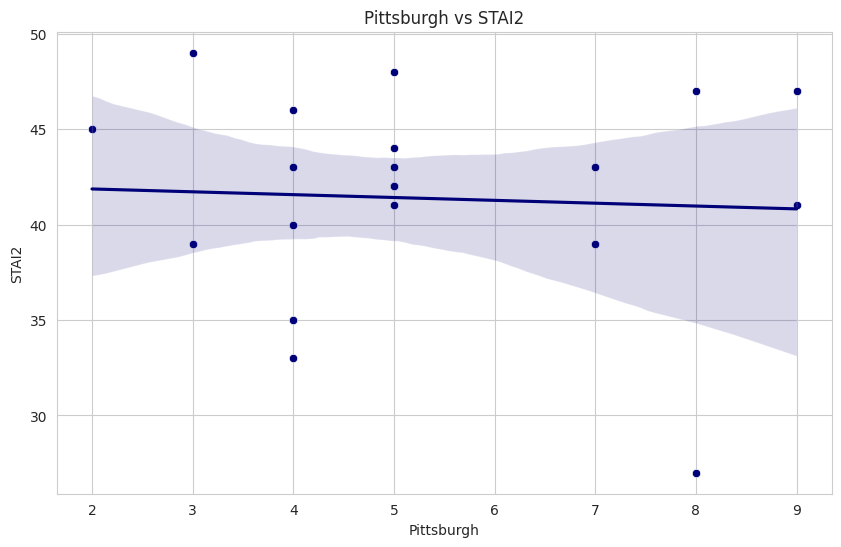

In [46]:
# Scatterplot de Pittsburgh vs STAI2
sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_quest, x='Pittsburgh', y='STAI2', color='#000078')
sns.regplot(data=df_quest, x='Pittsburgh', y='STAI2', scatter=False, color='#000078', ci=95)
plt.title('Pittsburgh vs STAI2')
plt.xlabel('Pittsburgh')
plt.ylabel('STAI2')
plt.show()


En principio se podría esperar que personas que duermen peor tengan una mayor ansiedad basal (STAI2), pero no parece haber una relación entre las variables. Es importate notar que tanto PSQI como STAI2 son variables subjetivas, por lo que la falta de correlación podría deberse a la subjetividad de las mediciones o bien a que estas no son adecuadas para medir la relación entre calidad del sueño y ansiedad basal.

**Daily_stress**

El Inventario de Estrés Diario (DSI) es una medida autoinformada de 58 ítems que permite a las personas indicar eventos estresantes en los que participaron en las últimas 24 horas. Además, los participantes deben indicar la magnitud de los eventos estresantes en una escala Likert de 1 (ocurrió pero no fue estresante) a 7 (me causó pánico). La variable Daily_stress proporciona una puntuación entre 0 y 406, donde valores más altos indican una mayor frecuencia y magnitud de los eventos estresantes percibidos durante el día.

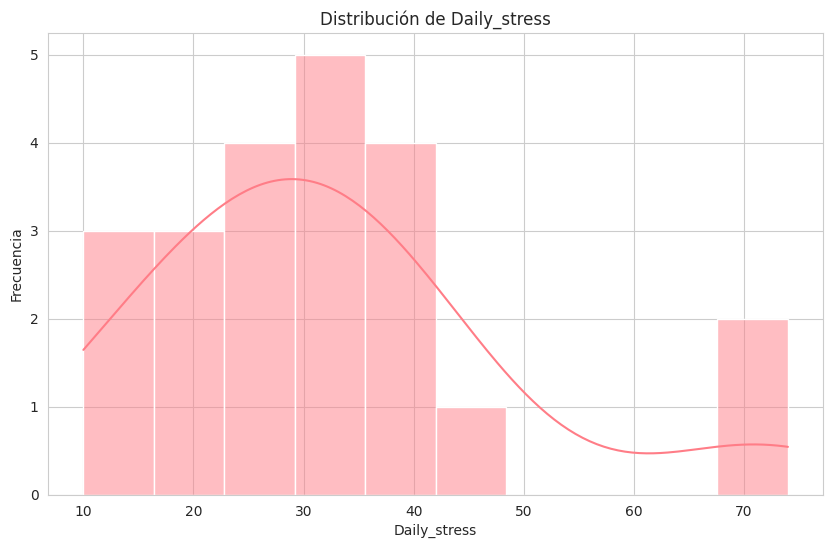

In [47]:
# Se muestra el histograma de Daily_stress
sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data=df_quest, x='Daily_stress', bins=10, kde=True, color="#FF7D87")
plt.title('Distribución de Daily_stress')
plt.xlabel('Daily_stress')
plt.ylabel('Frecuencia')

plt.show()

Se observa una distribución muy similar a la normal, pero con un repunte en torno a valores de 70, lo que la hace una distribución sesgada a la derecha. Los datos se centran en torno al valor 30, con valores mínimos de 10 y máximos de 74. Al igual que con las otras variables del cuestionario, aunque el rango de respuestas va de 0 a 406, la mayoría de los valores se encuentran en un rango de 0 a 80.

A continuación se muestra el gráfico de dispersión para mostrar la relación entre las variables Daily_stress y PSQI.

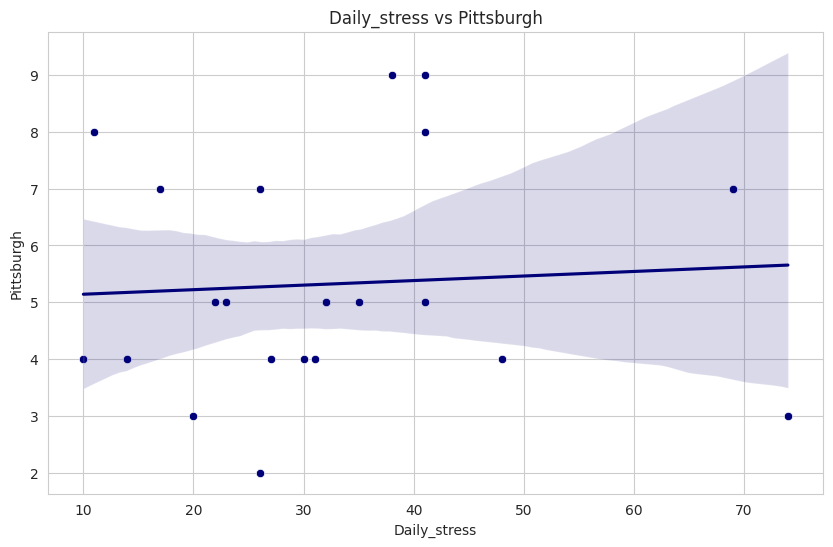

In [48]:
# Scatterplot de Daily_stress vs PSQI
sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_quest, x='Daily_stress', y='Pittsburgh', color='#000078')
sns.regplot(data=df_quest, x='Daily_stress', y='Pittsburgh', scatter=False, color='#000078', ci=95)
plt.title('Daily_stress vs Pittsburgh')
plt.xlabel('Daily_stress')
plt.ylabel('Pittsburgh')
plt.show()

De nuevo no se observa una correlación clara entre las variables. Por lo que no parece que los ususarios con mayor nivel de estrés diario tengan peor calidad de sueño, al menos en base a las respuestas subjetivas a los cuestionarios.

**BIB/BAS**

Las variables BIS/BAS miden cómo las personas responden a estímulos de castigo (BIS) y recompensa (BAS). El BIS está relacionado con la ansiedad y la evitación del riesgo, mientras que las subescalas del BAS evalúan la motivación y la respuesta a recompensas.

BIS (Sistema de Inhibición Conductual)
- El BIS mide la sensibilidad al castigo y la tendencia a evitar riesgos. Una puntuación alta indica mayor ansiedad y comportamiento cauteloso, mientras que una baja sugiere menor sensibilidad a estímulos negativos.

BAS (Sistema de Activación Conductual)
- BAS Reward Responsiveness: Mide la respuesta emocional positiva a recompensas. Puntuaciones altas indican mayor entusiasmo ante logros.
- BAS Drive: Evalúa la motivación para alcanzar metas. Puntuaciones altas reflejan determinación y persistencia.
- BAS Fun Seeking: Mide la búsqueda de experiencias nuevas y placenteras. Puntuaciones altas sugieren apertura a la novedad y disposición a actuar impulsivamente.


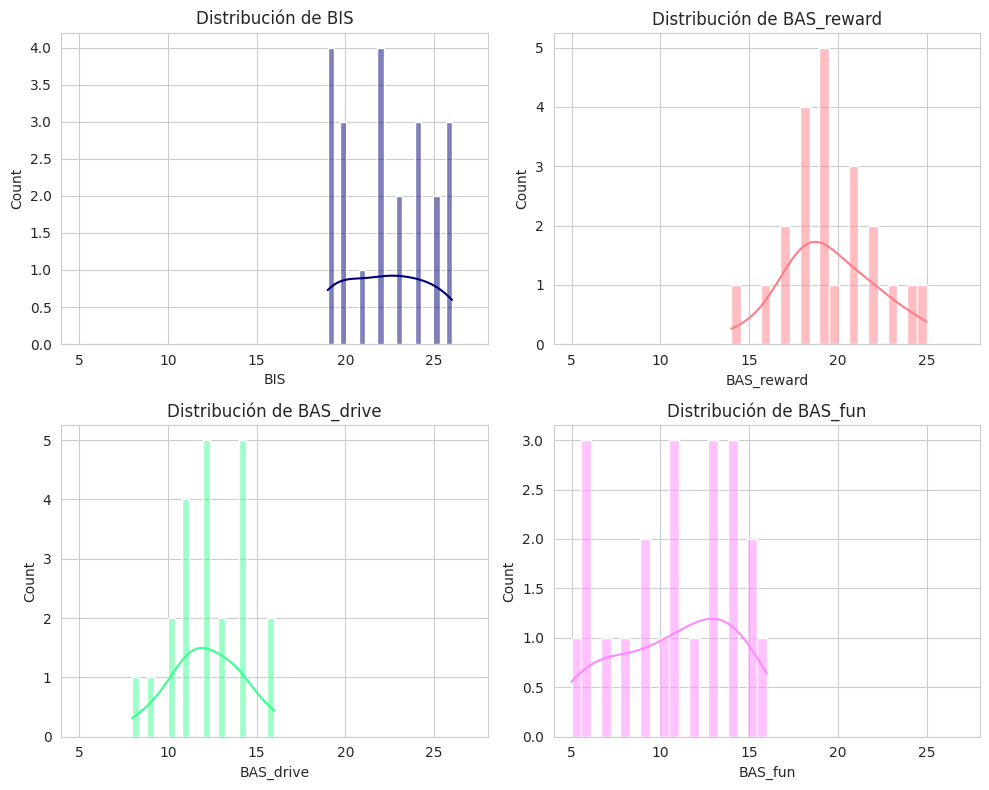

In [49]:
# Se muestra el histograma de las 4 variables de BIS/BAS
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Histograma de BIS
sns.histplot(data=df_quest, x='BISBAS_bis', bins=20, kde=True, color="#000078", ax=axes[0, 0])
axes[0, 0].set_title('Distribución de BIS')
axes[0, 0].set_xlabel('BIS')
axes[0, 0].set_xlim(4, 28)

# Histograma de BAS_reward
sns.histplot(data=df_quest, x='BISBAS_reward', bins=20, kde=True, color="#FF7D87", ax=axes[0, 1])
axes[0, 1].set_title('Distribución de BAS_reward')
axes[0, 1].set_xlabel('BAS_reward')
axes[0, 1].set_xlim(4, 28)

# Histograma de BAS_drive
sns.histplot(data=df_quest, x='BISBAS_drive', bins=20, kde=True, color="#38FF90", ax=axes[1, 0])
axes[1, 0].set_title('Distribución de BAS_drive')
axes[1, 0].set_xlabel('BAS_drive')
axes[1, 0].set_xlim(4, 28)

# Histograma de BAS_fun
sns.histplot(data=df_quest, x='BISBAS_fun', bins=20, kde=True, color="#FF87FF", ax=axes[1, 1])
axes[1, 1].set_title('Distribución de BAS_fun')
axes[1, 1].set_xlabel('BAS_fun')
axes[1, 1].set_xlim(4, 28)

plt.tight_layout()
plt.show()

En este caso, los valores altos de *BIS* sugieren que los participantes tienden a ser más sensibles al castigo y a evitar situaciones de riesgo, lo que puede estar relacionado con niveles más altos de ansiedad y comportamientos más cautelosos. Los valores observados para *BAS_reward* indican una respuesta emocional positiva moderada frente a recompensas, lo que sugiere que los participantes experimentan un entusiasmo moderado ante logros. Los valores observados para *BAS_drive* sugieren una motivación y persistencia moderada para alcanzar metas personales, indicando que los participantes tienen un impulso moderado para perseguir sus objetivos. Los valores observados para *BAS_fun* indican una búsqueda moderada de experiencias nuevas y placenteras, así como una disposición moderada a actuar de manera impulsiva, sugiriendo que los participantes tienen una apertura moderada a la novedad y un equilibrio entre impulsividad y autocontrol.


En base a cómo se describen las variables, aquellas personas que presentan más ansiedad en las variables STAI1 y STAI2 también deberían presentar un IBI más alto. Por lo tanto, se muestran dos diagramas de dispersión para ver si se cumple esta hipótesis.

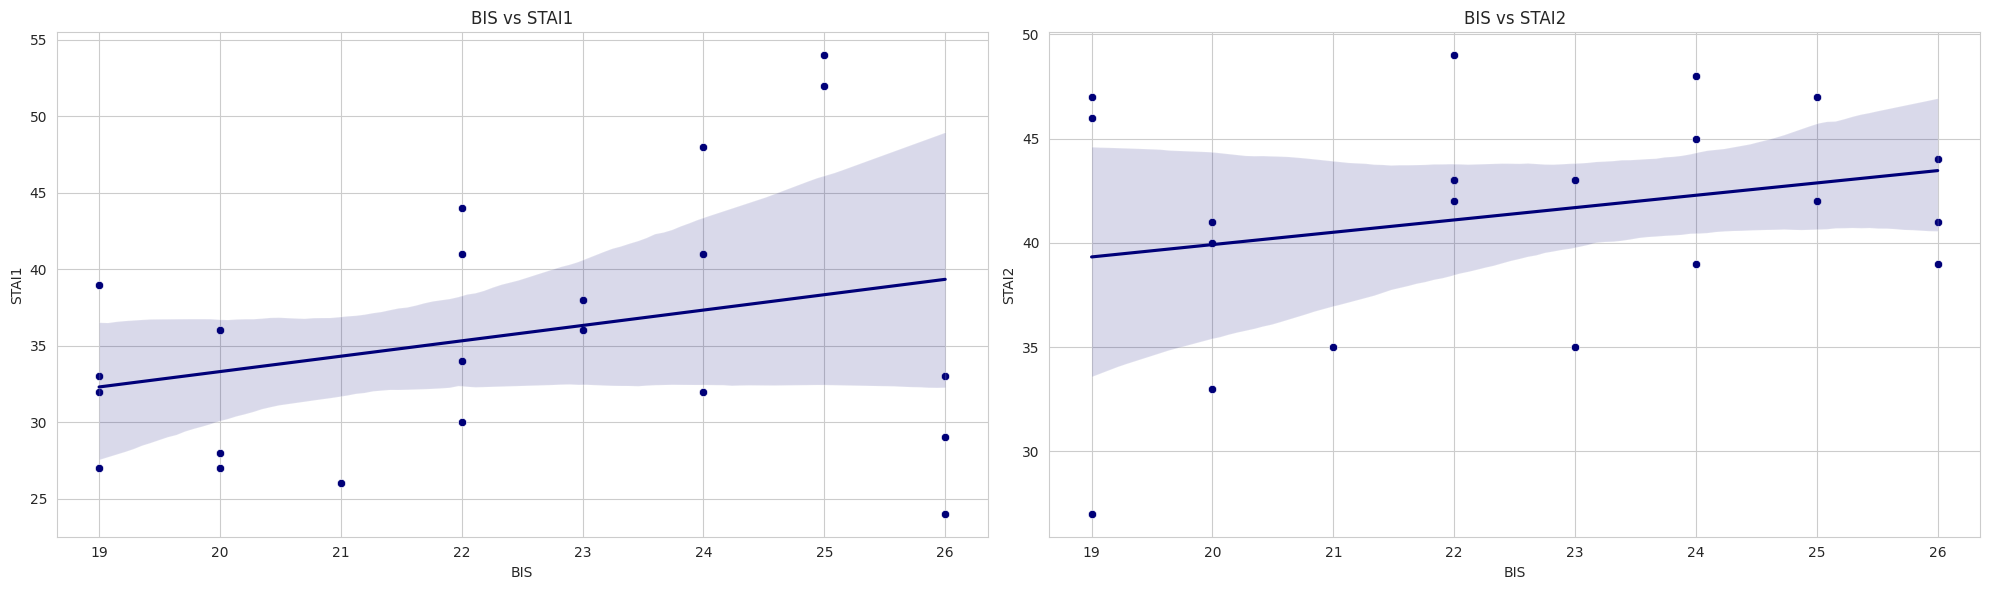

In [50]:
# Ploteamos dos scatter plots de BIS/BAS uno para STAI1 y otro para STAI2
sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Scatter plot de BIS/BAS vs STAI1
sns.scatterplot(data=df_quest, x='BISBAS_bis', y='STAI1', color='#000078', ax=axes[0])
sns.regplot(data=df_quest, x='BISBAS_bis', y='STAI1', scatter=False, color='#000078', ci=95, ax=axes[0])
axes[0].set_title('BIS vs STAI1')
axes[0].set_xlabel('BIS')
axes[0].set_ylabel('STAI1')

# Scatter plot de BIS/BAS vs STAI2
sns.scatterplot(data=df_quest, x='BISBAS_bis', y='STAI2', color='#000078', ax=axes[1])
sns.regplot(data=df_quest, x='BISBAS_bis', y='STAI2', scatter=False, color='#000078', ci=95, ax=axes[1])
axes[1].set_title('BIS vs STAI2')
axes[1].set_xlabel('BIS')
axes[1].set_ylabel('STAI2')

plt.tight_layout()
plt.show()

No se observa una correlación clara entre las variables BIS/BAS y STAI1 o STAI2. Aunque en ambos casos parece haber una leve correlación positiva, el bajo número de datos no permite sacar conclusiones claras. Por lo tanto, no se puede afirmar que exista una relación entre BIS y las variables STAI1 y STAI2. Cabe señalar que ambas son variables que miden la autopercepción del usuario, por lo que no son objetivas y pueden estar sesgadas.

**Panas Positivo y Negativo**

Las variables *panas_pos_10*, *panas_pos_14*, *panas_pos_18*, *panas_pos_22*, *panas_pos_9+1*, *panas_neg_10*, *panas_neg_14*, *panas_neg_18*, *panas_neg_22*, y *panas_neg_9+1* del conjunto de datos MMASH se refieren a las emociones positivas y negativas medidas en diferentes momentos del día. 
 - *panas_pos_10*, *panas_pos_14*, *panas_pos_18*, *panas_pos_22*, *panas_pos_9+1*: Miden las emociones positivas en diferentes horas del día. Por ejemplo, *panas_pos_10* mide la emoción positiva a las 10 AM, *panas_pos_14* a las 2 PM, y así sucesivamente. *panas_pos_9+1* indica las 9 AM del segundo día de registro. Valores altos indican emociones positivas fuertes, mientras que valores bajos indican emociones positivas débiles.
- *panas_neg_10*, *panas_neg_14*, *panas_neg_18*, *panas_neg_22*, *panas_neg_9+1*: Miden las emociones negativas en diferentes horas del día, siguiendo la misma lógica que las variables de emociones positivas. Valores altos indican emociones negativas fuertes, mientras que valores bajos indican emociones negativas débiles.
Las variables *panas_pos_10*, *panas_pos_14*, *panas_pos_18*, *panas_pos_22*, *panas_pos_9+1*, *panas_neg_10*, *panas_neg_14*, *panas_neg_18*, *panas_neg_22*, y *panas_neg_9+1* del conjunto de datos MMASH se refieren a las emociones positivas y negativas medidas en diferentes momentos del día. 

Estas variables permiten analizar cómo varían las emociones de los participantes a lo largo del día y entre días consecutivos. Indican tanto las emociones positivas como negativas y la intensidad de estas. El rango de valores va de 5 a 50.

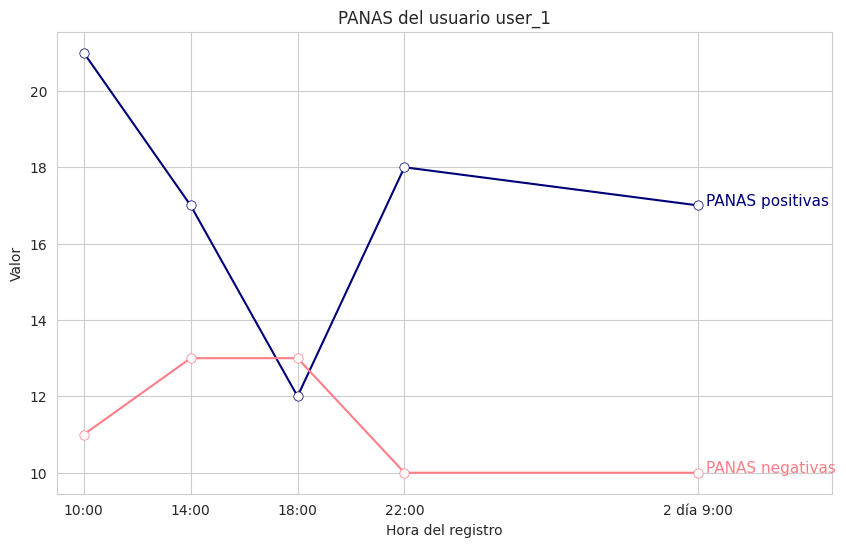

In [51]:
def plot_panas_per_user(df_user, ax):
    """
    Esta función recibe un dataframe de un usuario y devuelve el axis con la serie
    temporal de las variables PANAS positivas y negativas.

    Args:
    df_user (pd.DataFrame): DataFrame de un usuario
    ax (matplotlib.axis): Axis donde se va a pintar la serie temporal

    Returns:
    matplotlib.axis: Axis con la serie temporal de las variables PANAS
    """

    # Se crea una serie temporal con las variables PANAS
    panas_pos = df_user[['panas_pos_10', 'panas_pos_14', 'panas_pos_18', 'panas_pos_22', 'panas_pos_9+1']].melt()
    panas_neg = df_user[['panas_neg_10', 'panas_neg_14', 'panas_neg_18', 'panas_neg_22', 'panas_neg_9+1']].melt()

    panas_pos['variable'] = panas_pos['variable'].str.replace('panas_pos_', '')
    panas_neg['variable'] = panas_neg['variable'].str.replace('panas_neg_', '')

    # Se pinta la serie temporal
    sns.lineplot(data=panas_pos, x=[10, 14, 18, 22, 33], y='value', color='#000078', ax=ax)
    sns.lineplot(data=panas_neg, x=[10, 14, 18, 22, 33], y='value', color='#FF7D87', ax=ax)
    sns.scatterplot(data=panas_pos, x=[10, 14, 18, 22, 33], y='value', color='white', edgecolor='#000078', s=45, ax=ax, zorder=5)
    sns.scatterplot(data=panas_neg, x=[10, 14, 18, 22, 33], y='value', color='white', edgecolor='#FF7D87', s=45, ax=ax, zorder=5)
    ax.set_title(f'PANAS del usuario {df_user["User"].iloc[0]}')
    ax.set_xlabel('Hora del registro')
    ax.set_ylabel('Valor')
    ax.set_xticks([10, 14, 18, 22, 33])
    ax.set_xticklabels(['10:00', '14:00', '18:00', '22:00', '2 día 9:00'])

    # Se añade un identificador para cada serie
    ax.text(33.3, panas_pos['value'].iloc[-1], 'PANAS positivas', color='#000078', fontsize=11)
    ax.text(33.3, panas_neg['value'].iloc[-1], 'PANAS negativas', color='#FF7D87', fontsize=11)

    # Ajustamos el tamaño del eje X para que quepa el texto
    ax.set_xlim(9, 38)

    return ax

# Plot user 1
df_user1 = df_quest[df_quest['User'] == 'user_1']
fig, ax = plt.subplots(figsize=(10, 6))
plot_panas_per_user(df_user1, ax)
plt.show()

100%|██████████| 22/22 [00:02<00:00,  9.55it/s]


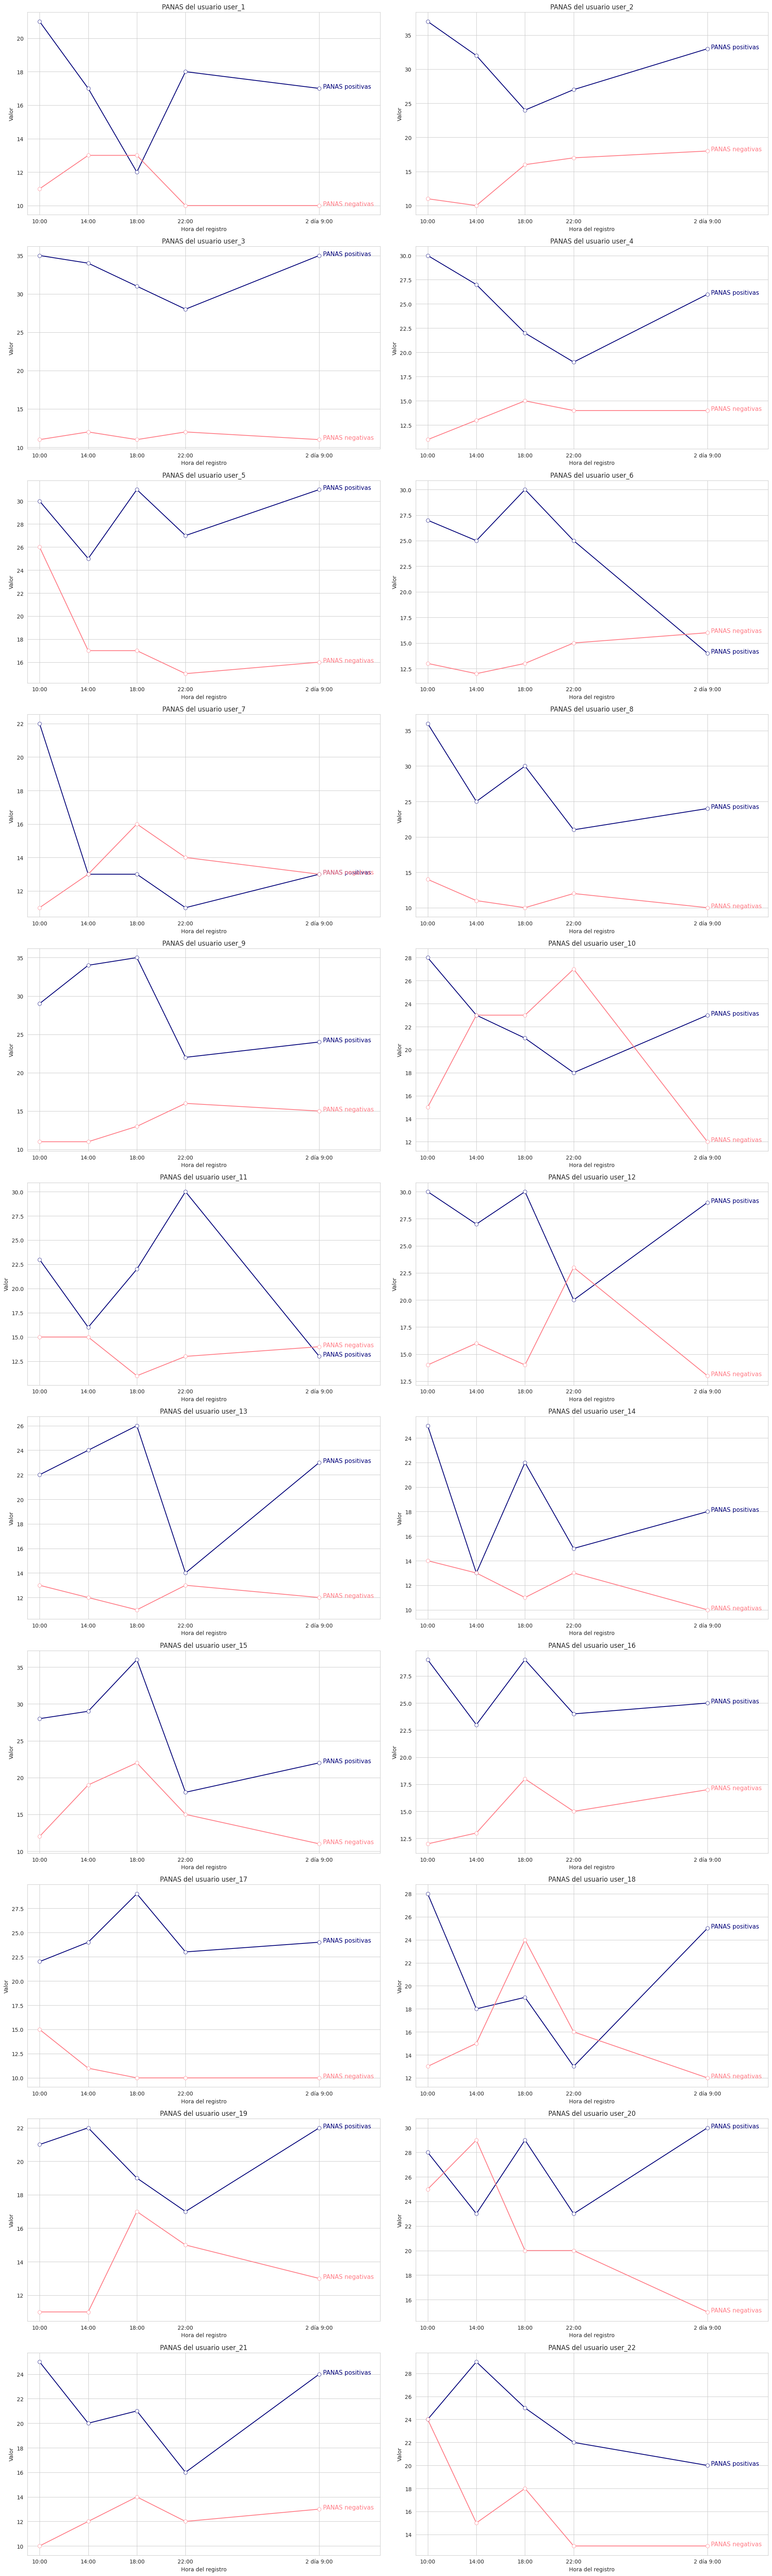

In [52]:
# Se plotean las series temporales de PANAS para todos los usuarios
users = sorted([x.split("/")[-2] for x in csv_files], key=lambda x: int(x.split('_')[1]))

# 2 columnas y tantas filas como sea necesario
ncols = 2
nrows = len(users) // ncols + (len(users) % ncols > 0)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 6 * nrows))

for user, ax in tqdm(zip(users, axes.flatten()), total=len(users)):
    df_user = df_quest[df_quest['User'] == user]
    plot_panas_per_user(df_user, ax)

# Se eliminan los ejes sobrantes
for ax in axes.flatten()[len(users):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

En términos generales, se observa que los usuarios contestan con valores de intensidad más altos a los sentimientos positivos que a los negativos. También se advierte que las bajadas de intensidad de los sentimientos positivos suelen ir acompañadas de subidas de los negativos y viceversa. En muy pocas ocasiones se observa que la intensidad de los sentimientos negativos supere a la de los sentimientos positivos.

Cuando se crucen estos datos con los de sueño, se podrá ver si aquellas personas con mayor intensidad en los sentimientos positivos tienen una mejor calidad del sueño. Así como si aquellas personas con mayor intensidad en los sentimientos negativos o que se van a la cama con un patrón creciente en la intensidad de emociones negativas. También veremos cómo el dormir hace que disminuyan o aumenten la intensidad de cada tipo de sentimiento y si hay relación con la calidad del sueño.

Analizaremos en términos generales si dormir mejora la intensidad de las emociones positivas y negativas.

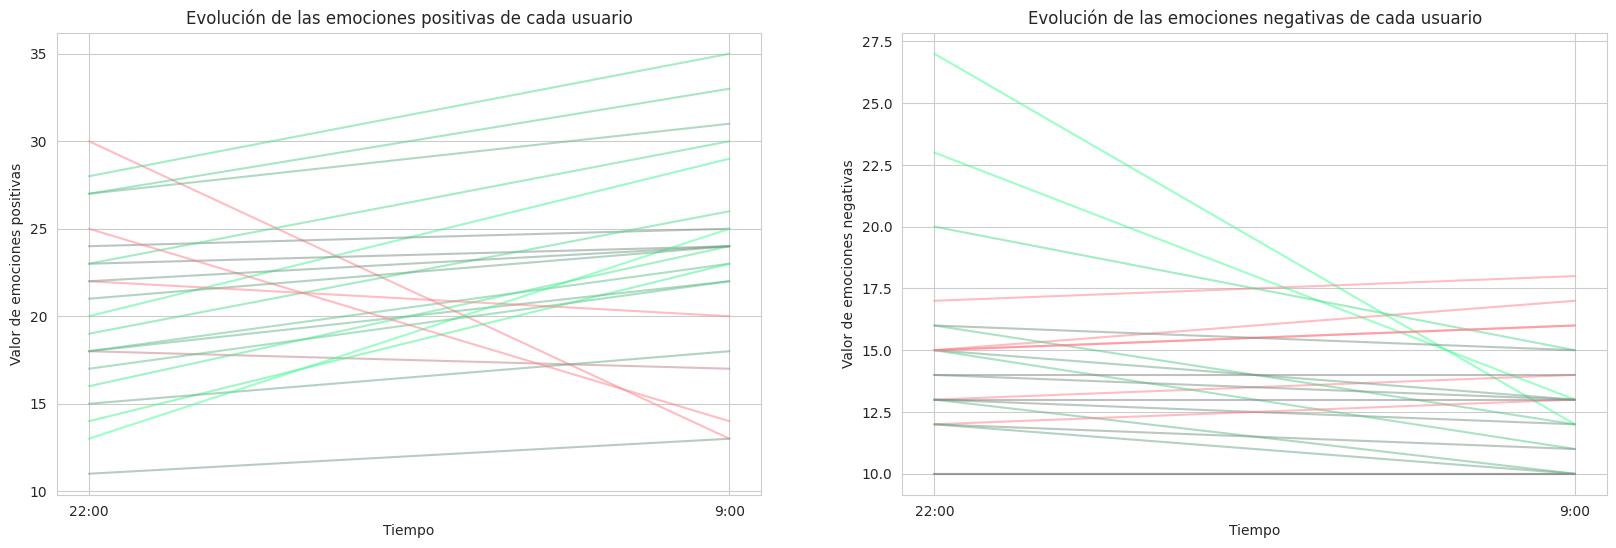

In [53]:
df_panas_sleep = df_quest[['User', 'panas_pos_22', 'panas_pos_9+1', 'panas_neg_22', 'panas_neg_9+1']]

# Filtramos las emociones positivas y negativas
df_panas_sleep_pos = df_panas_sleep[['User', 'panas_pos_22', 'panas_pos_9+1']]
df_panas_sleep_neg = df_panas_sleep[['User', 'panas_neg_22', 'panas_neg_9+1']]

# Ploteamos un diagrama de líneas con la evolución de las emociones positivas y negativas de cada usuario
sns.set_style('whitegrid')

df_panas_sleep_pos_melted = df_panas_sleep_pos.melt(id_vars='User', var_name='Time', value_name='Value')
df_panas_sleep_neg_melted = df_panas_sleep_neg.melt(id_vars='User', var_name='Time', value_name='Value')

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Definir los colores personalizados
colors = ['#FF7D87', 'gray', '#38FF90']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=10)

# Conectar los puntos con colores específicos para emociones positivas
for user, user_data in df_panas_sleep_pos_melted.groupby('User'):
    slope = user_data['Value'].iloc[1] - user_data['Value'].iloc[0]
    color = cmap(norm(slope))
    ax[0].plot(user_data['Time'], user_data['Value'], color=color, alpha=0.5)

ax[0].set_title('Evolución de las emociones positivas de cada usuario')
ax[0].set_xlabel('Tiempo')
ax[0].set_ylabel('Valor de emociones positivas')
ax[0].set_xticks(ticks=['panas_pos_22', 'panas_pos_9+1'])
ax[0].set_xticklabels(['22:00', '9:00'])

# Definir los colores personalizados
colors = ['#38FF90', 'gray', '#FF7D87']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
norm = TwoSlopeNorm(vmin=-7, vcenter=0, vmax=0.5)

# Conectar los puntos con colores específicos para emociones negativas
for user, user_data in df_panas_sleep_neg_melted.groupby('User'):
    slope = user_data['Value'].iloc[1] - user_data['Value'].iloc[0]
    color = cmap(norm(slope))
    ax[1].plot(user_data['Time'], user_data['Value'], color=color, alpha=0.5)

ax[1].set_title('Evolución de las emociones negativas de cada usuario')
ax[1].set_xlabel('Tiempo')
ax[1].set_ylabel('Valor de emociones negativas')
ax[1].set_xticks(ticks=['panas_neg_22', 'panas_neg_9+1'])
ax[1].set_xticklabels(['22:00', '9:00'])

plt.show()

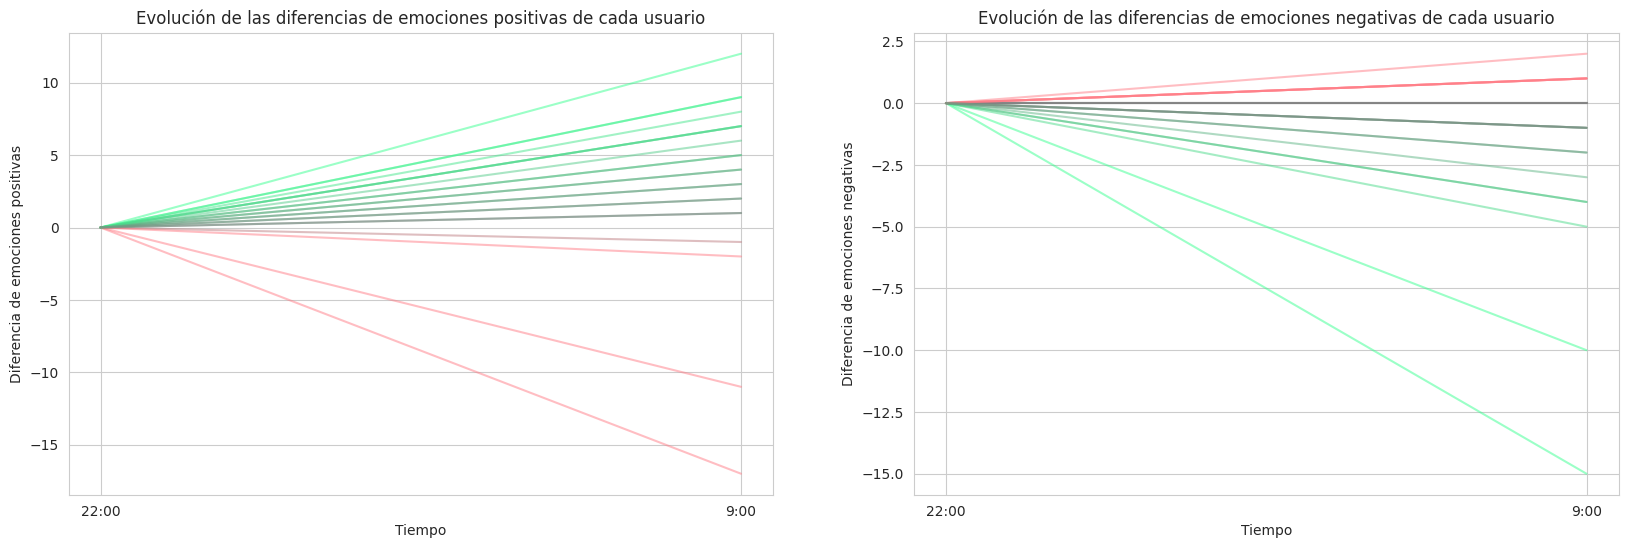

In [54]:
# Calculamos las diferencias de las emociones positivas y negativas, de manera que valores positivos indican un aumento de la intensidad de la emoción y valores negativos una disminución
df_panas_sleep_pos = df_panas_sleep_pos.copy()
df_panas_sleep_neg = df_panas_sleep_neg.copy()

df_panas_sleep_pos['diff_panas_pos'] = df_panas_sleep_pos['panas_pos_9+1'] - df_panas_sleep_pos['panas_pos_22']
df_panas_sleep_neg['diff_panas_neg'] = df_panas_sleep_neg['panas_neg_9+1'] - df_panas_sleep_neg['panas_neg_22']

# Seleccionamos las columans relevantes
df_panas_sleep_pos_diff = df_panas_sleep_pos.copy()[['User', 'diff_panas_pos']]
df_panas_sleep_neg_diff = df_panas_sleep_neg.copy()[['User', 'diff_panas_neg']]

# Renombramos las columnas
df_panas_sleep_pos_diff.rename(columns={'diff_panas_pos': '9+1 panas pos'}, inplace=True)
df_panas_sleep_neg_diff.rename(columns={'diff_panas_neg': '9+1 panas neg'}, inplace=True)

# Creamos los valores para las 22:00 que serán todos de 0
df_panas_sleep_pos_diff['22 panas pos'] = 0
df_panas_sleep_neg_diff['22 panas neg'] = 0

# Reordenamos las columnas
df_panas_sleep_pos_diff = df_panas_sleep_pos_diff[['User', '22 panas pos', '9+1 panas pos']]
df_panas_sleep_neg_diff = df_panas_sleep_neg_diff[['User', '22 panas neg', '9+1 panas neg']]

# Ploteamos un diagrama de líneas con la evolución de las diferencias de emociones positivas y negativas de cada usuario
sns.set_style('whitegrid')

df_panas_sleep_pos_diff_melted = df_panas_sleep_pos_diff.melt(id_vars='User', var_name='Time', value_name='Value')
df_panas_sleep_neg_diff_melted = df_panas_sleep_neg_diff.melt(id_vars='User', var_name='Time', value_name='Value')

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Definir los colores personalizados
colors = ['#FF7D87', 'gray', '#38FF90']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=10)

# Conectar los puntos con colores específicos para diferencias de emociones positivas
for user, user_data in df_panas_sleep_pos_diff_melted.groupby('User'):
    slope = user_data['Value'].iloc[1] - user_data['Value'].iloc[0]
    color = cmap(norm(slope))
    ax[0].plot(user_data['Time'], user_data['Value'], color=color, alpha=0.5)

ax[0].set_title('Evolución de las diferencias de emociones positivas de cada usuario')
ax[0].set_xlabel('Tiempo')
ax[0].set_ylabel('Diferencia de emociones positivas')
ax[0].set_xticks(ticks=['22 panas pos', '9+1 panas pos'])
ax[0].set_xticklabels(['22:00', '9:00'])

# Definir los colores personalizados
colors = ['#38FF90', 'gray', '#FF7D87']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
norm = TwoSlopeNorm(vmin=-7, vcenter=0, vmax=0.5)

# Conectar los puntos con colores específicos para diferencias de emociones negativas
for user, user_data in df_panas_sleep_neg_diff_melted.groupby('User'):
    slope = user_data['Value'].iloc[1] - user_data['Value'].iloc[0]
    color = cmap(norm(slope))
    ax[1].plot(user_data['Time'], user_data['Value'], color=color, alpha=0.5)

ax[1].set_title('Evolución de las diferencias de emociones negativas de cada usuario')
ax[1].set_xlabel('Tiempo')
ax[1].set_ylabel('Diferencia de emociones negativas')
ax[1].set_xticks(ticks=['22 panas neg', '9+1 panas neg'])
ax[1].set_xticklabels(['22:00', '9:00'])

plt.show()

In [55]:
# Contar cuántos usuarios mejoran, empeoran o mantienen sus emociones positivas
pos_improve = (df_panas_sleep_pos['diff_panas_pos'] > 1).sum()
pos_worsen = (df_panas_sleep_pos['diff_panas_pos'] < -1).sum()
pos_same = ((df_panas_sleep_pos['diff_panas_pos'] >= -1) & (df_panas_sleep_pos['diff_panas_pos'] <= 1)).sum()

# Contar cuántos usuarios mejoran, empeoran o mantienen sus emociones negativas
neg_improve = (df_panas_sleep_neg['diff_panas_neg'] < -1).sum()
neg_worsen = (df_panas_sleep_neg['diff_panas_neg'] > 1).sum()
neg_same = ((df_panas_sleep_neg['diff_panas_neg'] >= -1) & (df_panas_sleep_neg['diff_panas_neg'] <= 1)).sum()

print(f"Usuarios que mejoran sus emociones positivas: {pos_improve}")
print(f"Usuarios que empeoran sus emociones positivas: {pos_worsen}")
print(f"Usuarios que mantienen sus emociones positivas: {pos_same}")
print()
print(f"Usuarios que mejoran sus emociones negativas: {neg_improve}")
print(f"Usuarios que empeoran sus emociones negativas: {neg_worsen}")
print(f"Usuarios que mantienen sus emociones negativas: {neg_same}")

Usuarios que mejoran sus emociones positivas: 16
Usuarios que empeoran sus emociones positivas: 3
Usuarios que mantienen sus emociones positivas: 3

Usuarios que mejoran sus emociones negativas: 8
Usuarios que empeoran sus emociones negativas: 1
Usuarios que mantienen sus emociones negativas: 13


La mayoría de los usuarios (16 de 22) mejoran sus emociones positivas después de dormir, mientras que 3 usuarios empeoran y 3 usuarios mantienen sus emociones positivas sin cambios significativos. En cuanto a las emociones negativas, 8 usuarios mejoran, 1 usuario empeora y 13 usuarios mantienen sus emociones negativas sin cambios significativos. Para considerar que mejoran o empeoran, se ha tenido en cuenta que haya al menos 1 punto de diferencia.

En resumen, el sueño parece tener un efecto significativamente positivo en la mejora de las emociones tanto positivas como negativas. Tal y como se observa en los gráficos. Si bien, cabe destacar que hay una mayor variabilidad al dormir en la intensidad de las emociones positivas que en las negativas. Esto ya se detectava al ver que los usuarios manifestaban un mayor intensidad en estas emociones, po lo que es normal que los cmabios sean mayores.

# 2. Guardamos el dataframe como un fichero pickle

In [56]:
out_folder = os.path.join('..', '0_data', "clean_MMASH")
filename = 'questionnaire.pkl'

# Comprobamos si la carpeta existe, si no la creamos
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

# Comprobamos si el archivo existe, de ser así lo eliminamos
if os.path.exists(os.path.join(out_folder, filename)):
    os.remove(os.path.join(out_folder, filename))

# Guardamos el df en un archivo pickle
df_quest["User_order"] = df_quest["User"].str.extract(r'(\d+)').astype(int)
df_quest = df_quest.sort_values("User_order").drop(columns="User_order")
df_quest.reset_index(drop=True, inplace=True)
df_quest.to_pickle(os.path.join(out_folder, filename))

# Bibliografía

[1]: Rossi, A., Da Pozzo, E., Menicagli, D., Tremolanti, C., Priami, C., Sîrbu, A., Clifton, D. A., Martini, C., & Morelli, D. (2020). A Public Dataset of 24-h Multi-Levels Psycho-Physiological Responses in Young Healthy Adults. Data, 5(4), 91. https://doi.org/10.3390/data5040091